# Technical Test for Biostatistical Analysis of Clinical Data
- Just Run All cells

# Pre-analysis:

# Combine the BCA Data Sheets
We’ll first combine all sheets from the BCA data into one DataFrame with Patient Clinical data

In [257]:
import pandas as pd

# Define file paths
clinical_file_path = r'C:\Users\anish\Downloads\Technicial_test\PDAC_Patient_clinical_data.xlsx'
bca_file_path = r'C:\Users\anish\Downloads\Technicial_test\PDAC_Patient_BCA_data.xlsx'

# Load the clinical data
clinical_data = pd.read_excel(clinical_file_path)

# Load all sheets from the BCA data
bca_data_all_sheets = pd.read_excel(bca_file_path, sheet_name=None, header=1)  # header=1 to skip the first row (column names)

# Start with the clinical data
merged_df = clinical_data

# Merge each sheet from the BCA data with the clinical data
for sheet_name, bca_df in bca_data_all_sheets.items():
    # Merge the current BCA sheet with the clinical data on 'ID'
    merged_df = pd.merge(merged_df, bca_df, on='ID', how='inner', suffixes=('', f'_{sheet_name}'))

# Export the merged data to Excel
merged_df.to_excel(r'C:\Users\anish\Downloads\Technicial_test\Merged_PDAC_Clinical_BCA_Data.xlsx', index=False)

# Show a sample of the merged dataframe
print(merged_df.head(5))

         ID sex (MALE/FEMALE)  date_of_birth  pat_deathday  end of follow-up   \
0  60081820            FEMALE            NaN           NaN                NaN   
1  60495901              MALE            NaN           NaN                NaN   
2   1450976              MALE            NaN           NaN                NaN   
3   1382339            FEMALE            NaN           NaN                NaN   
4  60525551              MALE            NaN           NaN                NaN   

   date_of_CTscan  CT-scan (INTERN/EXTERN)  layer thickness (mm)  \
0           -67.0                      NaN                   NaN   
1            -3.0                      NaN                   NaN   
2            -8.0                      NaN                   NaN   
3            -5.0                      NaN                   NaN   
4           -18.0                      NaN                   NaN   

   non-contrast phase (yes/no) arterial phase (yes/no)   ...  \
0                          NaN          

In [258]:
merged_df.columns = merged_df.columns.str.strip()  # Remove leading/trailing spaces

# Data-Analysis:

# Missing Data Report:
Calculates and outputs a summary of missing data for each variable.

In [259]:
# Missing Data Report
missing_report = merged_df.isnull().sum().to_frame(name='Missing Count')
missing_report['Missing %'] = (missing_report['Missing Count'] / len(merged_df)) * 100
missing_report.to_csv(r'C:\Users\anish\Downloads\Technicial_test\Missing_Data_Report.csv')

# Data Imputation (if necessary)
Imputes missing values for continuous and categorical variables using different methods.

In [260]:
from sklearn.impute import SimpleImputer

# Separate the columns into numerical and categorical
num_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns
cat_columns = merged_df.select_dtypes(include=['object']).columns

# Filter out columns with all missing values from numerical and categorical columns
num_columns_valid = num_columns[merged_df[num_columns].notnull().any()]
cat_columns_valid = cat_columns[merged_df[cat_columns].notnull().any()]

# Initialize imputers for numerical and categorical columns
num_imputer = SimpleImputer(strategy='mean')  # For numerical columns, use the mean
cat_imputer = SimpleImputer(strategy='most_frequent')  # For categorical columns, use the most frequent value

# Impute the numerical columns (those with at least one non-missing value)
merged_df[num_columns_valid] = num_imputer.fit_transform(merged_df[num_columns_valid])

# Impute the categorical columns (those with at least one non-missing value)
merged_df[cat_columns_valid] = cat_imputer.fit_transform(merged_df[cat_columns_valid])

# Export the imputed data to a new Excel file
merged_df.to_excel(r'C:\Users\anish\Downloads\Technicial_test\Imputed_PDAC_Clinical_BCA_Data.xlsx', index=False)

# Show a sample of the imputed dataframe
print(merged_df.head(5))


           ID sex (MALE/FEMALE)  date_of_birth  pat_deathday  \
0  60081820.0            FEMALE            NaN           NaN   
1  60495901.0              MALE            NaN           NaN   
2   1450976.0              MALE            NaN           NaN   
3   1382339.0            FEMALE            NaN           NaN   
4  60525551.0              MALE            NaN           NaN   

   end of follow-up  date_of_CTscan  CT-scan (INTERN/EXTERN)  \
0               NaN           -67.0                      NaN   
1               NaN            -3.0                      NaN   
2               NaN            -8.0                      NaN   
3               NaN            -5.0                      NaN   
4               NaN           -18.0                      NaN   

   layer thickness (mm)  non-contrast phase (yes/no) arterial phase (yes/no)  \
0                   NaN                          NaN                     yes   
1                   NaN                          NaN                  

# Normality Test for Total Muscle Volume & Total Adipose Tissue Volume
This section tests the normality of these two variables using the Shapiro-Wilk test.

Shapiro-Wilk Test for Muscle Volume: p=8.340244004865488e-05
Shapiro-Wilk Test for Adipose Volume: p=0.01651580144413359


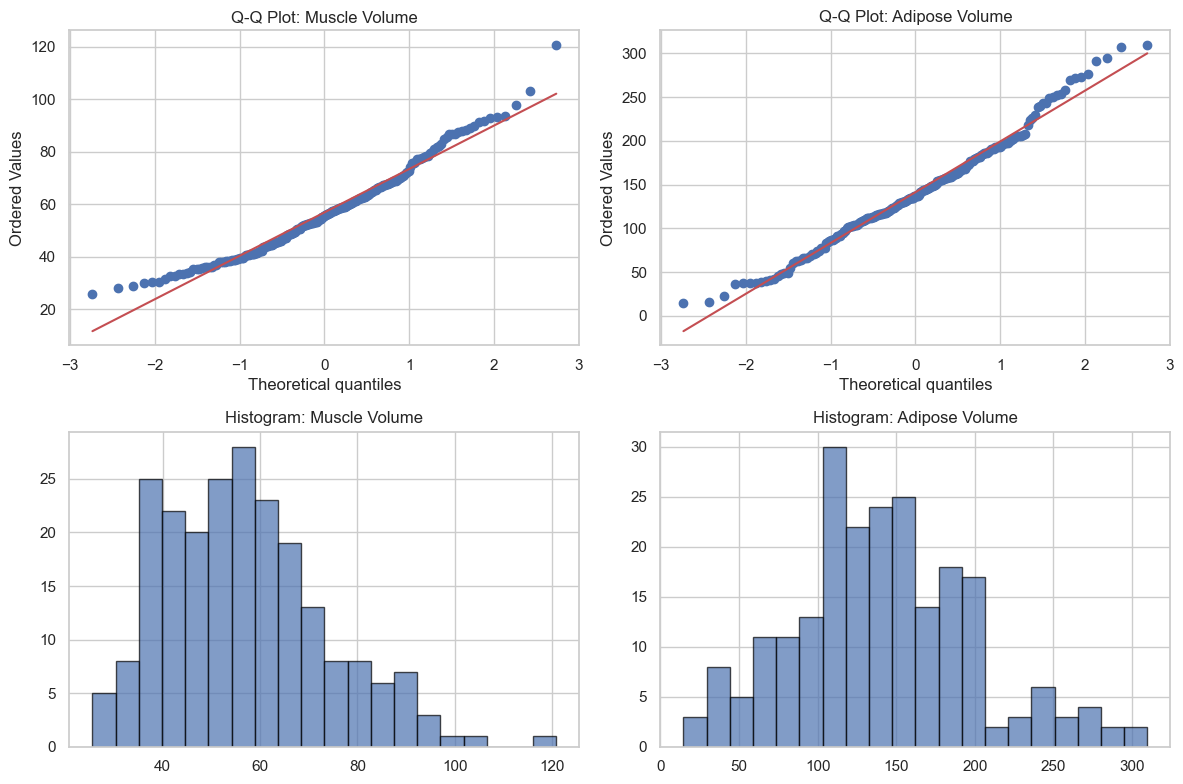

In [261]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Normality Test for Total Muscle Volume and Total Adipose Tissue Volume
muscle_vol = merged_df['whole_scan_muscle volume (mean)'].dropna()
adipose_vol = merged_df['whole_scan_total adipose tissue vol (mean)'].dropna()

shapiro_muscle = stats.shapiro(muscle_vol)
shapiro_adipose = stats.shapiro(adipose_vol)

print(f"Shapiro-Wilk Test for Muscle Volume: p={shapiro_muscle.pvalue}")
print(f"Shapiro-Wilk Test for Adipose Volume: p={shapiro_adipose.pvalue}")

# Q-Q Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Q-Q plots
stats.probplot(muscle_vol, dist="norm", plot=axes[0, 0])
axes[0, 0].set_title("Q-Q Plot: Muscle Volume")

stats.probplot(adipose_vol, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot: Adipose Volume")

# Histograms
axes[1, 0].hist(muscle_vol, bins=20, edgecolor="black", alpha=0.7)
axes[1, 0].set_title("Histogram: Muscle Volume")

axes[1, 1].hist(adipose_vol, bins=20, edgecolor="black", alpha=0.7)
axes[1, 1].set_title("Histogram: Adipose Volume")

plt.tight_layout()
plt.show()

# Summary Table for Clinical Variables
This section computes the descriptive statistics for both continuous and categorical variables.

In [262]:
import pandas as pd

# Separate continuous and categorical variables
continuous_vars = ['tumor size (mm)', 'CA19-9 before surgery', 'CEA before surgery', 
                   'Overall survival in months from diagnosis', 'Progression-free survival in months from diagnosis']

categorical_vars = ['sex (MALE/FEMALE)', 'non-contrast phase (yes/no)', 'arterial phase (yes/no)',
                    'venous phase (yes/no)', 'neoadjuvant therapy (yes/no)', 'adjuvant therapy (yes/no)',
                    'arterial invasion (AMS, TC, A. hep.) yes/no', 'venous invasion yes/no', 'Grading', 
                    'R-classification', 'Death during follow-up', 'Progression during follow-up (yes,no)']

# Summary for continuous variables
continuous_summary = merged_df[continuous_vars].describe().T  # Transpose for better readability

# Summary for categorical variables (counts & percentages)
categorical_summary = merged_df[categorical_vars].apply(lambda x: x.value_counts()).T
categorical_summary['Missing'] = merged_df[categorical_vars].isnull().sum()

# Combine summaries
summary_table = pd.concat([continuous_summary, categorical_summary], axis=0)

# Display summary
print(summary_table)

                                                    count        mean  \
tumor size (mm)                                     223.0   34.528571   
CA19-9 before surgery                               223.0  628.950355   
CEA before surgery                                  223.0    8.011811   
Overall survival in months from diagnosis           223.0   13.537668   
Progression-free survival in months from diagnosis    0.0         NaN   
sex (MALE/FEMALE)                                     NaN         NaN   
non-contrast phase (yes/no)                           NaN         NaN   
arterial phase (yes/no)                               NaN         NaN   
venous phase (yes/no)                                 NaN         NaN   
neoadjuvant therapy (yes/no)                          NaN         NaN   
adjuvant therapy (yes/no)                             NaN         NaN   
arterial invasion (AMS, TC, A. hep.) yes/no           NaN         NaN   
venous invasion yes/no                             

# Survival Analysis for Neoadjuvant & Adjuvant Therapy
This section uses Kaplan-Meier curves, Log-rank tests, and Cox proportional hazards models to analyze survival.

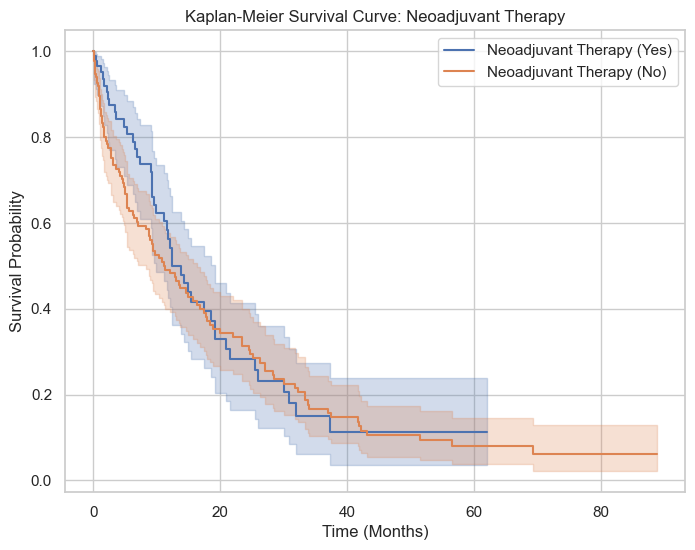

In [282]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

plt.figure(figsize=(8,6))

# Fit & plot survival for "Neoadjuvant Therapy Yes"
kmf_yes.fit(group_neoadjuvant_yes['Overall survival in months from diagnosis'], 
            event_observed=group_neoadjuvant_yes['Death during follow-up'], 
            label="Neoadjuvant Therapy (Yes)")
kmf_yes.plot_survival_function()

# Fit & plot survival for "Neoadjuvant Therapy No"
kmf_no.fit(group_neoadjuvant_no['Overall survival in months from diagnosis'], 
           event_observed=group_neoadjuvant_no['Death during follow-up'], 
           label="Neoadjuvant Therapy (No)")
kmf_no.plot_survival_function()

# Labels & Show Plot
plt.title("Kaplan-Meier Survival Curve: Neoadjuvant Therapy")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

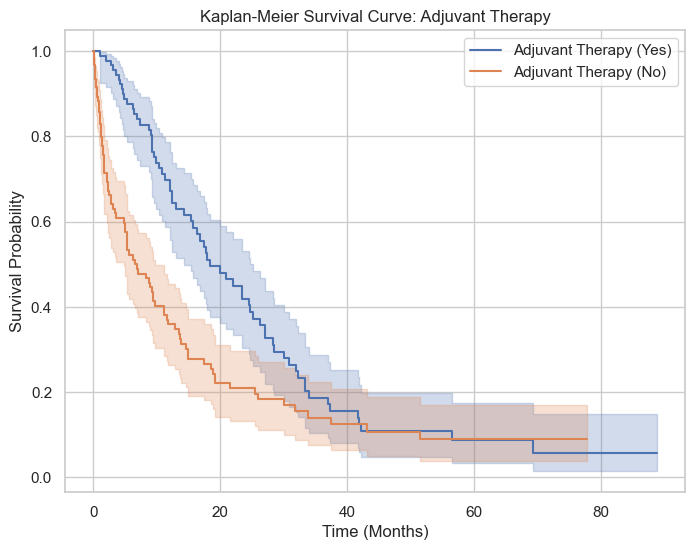

In [283]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier fitters
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

plt.figure(figsize=(8, 6))

# Fit & plot survival for "Adjuvant Therapy Yes"
kmf_yes.fit(group_adjuvant_yes['Overall survival in months from diagnosis'], 
            event_observed=group_adjuvant_yes['Death during follow-up'], 
            label="Adjuvant Therapy (Yes)")
kmf_yes.plot_survival_function()

# Fit & plot survival for "Adjuvant Therapy No"
kmf_no.fit(group_adjuvant_no['Overall survival in months from diagnosis'], 
           event_observed=group_adjuvant_no['Death during follow-up'], 
           label="Adjuvant Therapy (No)")
kmf_no.plot_survival_function()

# Labels & Show Plot
plt.title("Kaplan-Meier Survival Curve: Adjuvant Therapy")
plt.xlabel("Time (Months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


In [265]:
from lifelines.statistics import logrank_test

# Log-rank test for Neoadjuvant Therapy
results_neoadjuvant = logrank_test(
    group_neoadjuvant_yes['Overall survival in months from diagnosis'], 
    group_neoadjuvant_no['Overall survival in months from diagnosis'],
    event_observed_A=group_neoadjuvant_yes['Death during follow-up'],
    event_observed_B=group_neoadjuvant_no['Death during follow-up']
)

print("Neoadjuvant Therapy Log-Rank Test p-value:", results_neoadjuvant.p_value)


Neoadjuvant Therapy Log-Rank Test p-value: 0.022463153389139543


In [269]:
from lifelines.statistics import logrank_test

# Adjuvant Therapy: Log-rank test
results_adjuvant = logrank_test(
    group_adjuvant_yes['Overall survival in months from diagnosis'], 
    group_adjuvant_no['Overall survival in months from diagnosis'],
    event_observed_A=group_adjuvant_yes['Death during follow-up'],
    event_observed_B=group_adjuvant_no['Death during follow-up']
)
print("Adjuvant Therapy Log-Rank Test p-value:", results_adjuvant.p_value)


Adjuvant Therapy Log-Rank Test p-value: 0.00043219306455148323


<lifelines.CoxPHFitter: fitted with 223 total observations, 72 right-censored observations>
             duration col = 'Overall survival in months from diagnosis'
                event col = 'Death during follow-up'
      baseline estimation = breslow
   number of observations = 223
number of events observed = 151
   partial log-likelihood = -662.78
         time fit was run = 2025-02-14 01:52:59 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
adjuvant therapy (yes/no) -0.58      0.56      0.16           -0.90           -0.25                0.41                0.78

                           cmp to     z      p  -log2(p)
covariate                                               
adjuvant therapy (yes/no)    0.00 -3.50 <0.005     11.06
---
Concordance = 0.63
Partial AIC = 1327.56
log-likelihood ratio test = 12.37 on 1 df
-log2(p) of ll-ratio test = 11.16

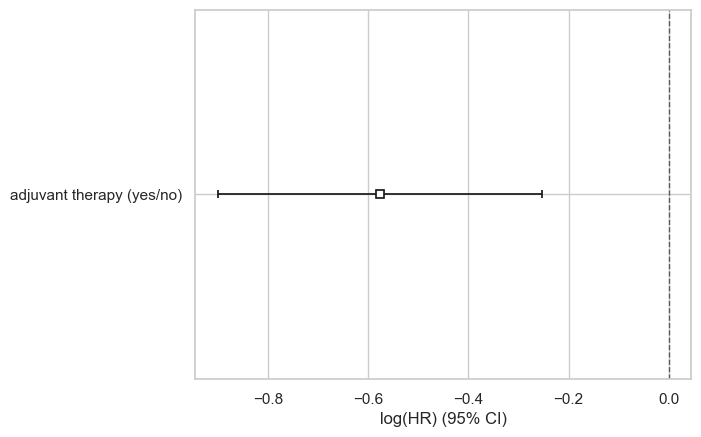

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# Ensure numeric conversion
merged_df['Overall survival in months from diagnosis'] = pd.to_numeric(merged_df['Overall survival in months from diagnosis'], errors='coerce')

# Convert 'Death during follow-up' to binary (1 for 'yes', 0 for 'no')
merged_df['Death during follow-up'] = merged_df['Death during follow-up'].map({'yes': 1, 'no': 0}).astype(int)

# Convert 'adjuvant therapy (yes/no)' to binary (1 = Yes, 0 = No)
merged_df['adjuvant therapy (yes/no)'] = merged_df['adjuvant therapy (yes/no)'].map({'yes': 1, 'no': 0}).astype(int)

# Initialize Cox Proportional Hazards Model
cph = CoxPHFitter()

# Selecting relevant columns for the model
df_cox = merged_df[['Overall survival in months from diagnosis', 'Death during follow-up', 'adjuvant therapy (yes/no)']].dropna()

# Fit the Cox model
cph.fit(df_cox, duration_col='Overall survival in months from diagnosis', event_col='Death during follow-up')

# Display summary results
cph.print_summary()

# Plot the Cox proportional hazards model
cph.plot()
plt.show()


<lifelines.CoxPHFitter: fitted with 223 total observations, 72 right-censored observations>
             duration col = 'Overall survival in months from diagnosis'
                event col = 'Death during follow-up'
      baseline estimation = breslow
   number of observations = 223
number of events observed = 151
   partial log-likelihood = -668.65
         time fit was run = 2025-02-14 01:54:57 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
neoadjuvant therapy (yes/no) -0.14      0.87      0.18           -0.49            0.21                0.61                1.23

                              cmp to     z    p  -log2(p)
covariate                                                
neoadjuvant therapy (yes/no)    0.00 -0.79 0.43      1.21
---
Concordance = 0.54
Partial AIC = 1339.30
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.23

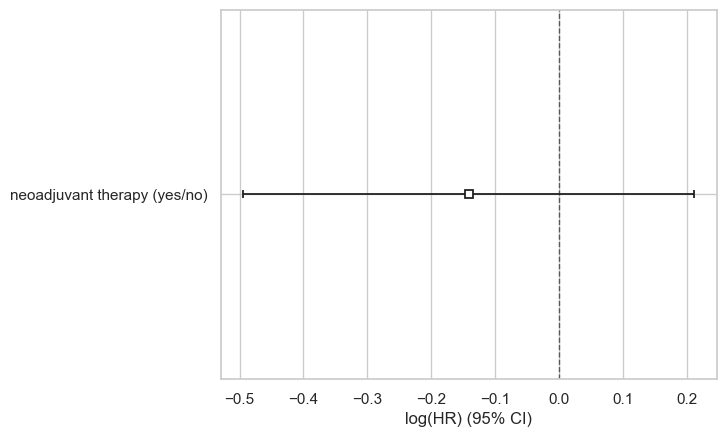

In [285]:
from lifelines import CoxPHFitter

# Convert 'Neoadjuvant Therapy (yes/no)' to binary (1 = Yes, 0 = No)
merged_df['neoadjuvant therapy (yes/no)'] = merged_df['neoadjuvant therapy (yes/no)'].map({'yes': 1, 'no': 0}).astype(int)

# Selecting relevant columns for the model
df_cox_neoadjuvant = merged_df[['Overall survival in months from diagnosis', 'Death during follow-up', 'neoadjuvant therapy (yes/no)']].dropna()

# Initialize Cox Proportional Hazards Model
cph_neoadjuvant = CoxPHFitter()

# Fit the Cox model for Neoadjuvant Therapy
cph_neoadjuvant.fit(df_cox_neoadjuvant, duration_col='Overall survival in months from diagnosis', event_col='Death during follow-up')

# Display summary results
cph_neoadjuvant.print_summary()

# Plot the Cox proportional hazards model for Neoadjuvant Therapy
cph_neoadjuvant.plot()
plt.show()


<lifelines.CoxPHFitter: fitted with 223 total observations, 72 right-censored observations>
             duration col = 'Overall survival in months from diagnosis'
                event col = 'Death during follow-up'
      baseline estimation = breslow
   number of observations = 223
number of events observed = 151
   partial log-likelihood = -661.82
         time fit was run = 2025-02-14 01:55:09 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
adjuvant therapy (yes/no)    -0.61      0.54      0.17           -0.94           -0.29                0.39                0.75
neoadjuvant therapy (yes/no) -0.25      0.78      0.18           -0.60            0.11                0.55                1.11

                              cmp to     z      p  -log2(p)
covariate                                                  
adjuvant therapy (yes/no)       0.00 -3.68 <0.005     12.05
neoadjuvant therapy (yes/no)    0.00 -1.37   0.17      2.54
---
Concordance = 0.65
Partial AIC = 1327.64
log-likelihood ratio test = 14.29 on 2 df
-log2(p) of ll-ratio test = 10.31

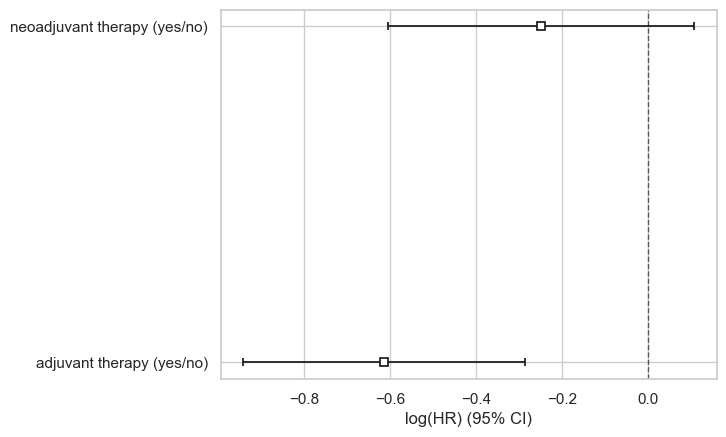

In [286]:
# Combined model for both therapies
df_cox_combined = merged_df[['Overall survival in months from diagnosis', 'Death during follow-up', 
                             'adjuvant therapy (yes/no)', 'neoadjuvant therapy (yes/no)']].dropna()

cph_combined = CoxPHFitter()
cph_combined.fit(df_cox_combined, duration_col='Overall survival in months from diagnosis', event_col='Death during follow-up')

cph_combined.print_summary()
cph_combined.plot()
plt.show()


# Intramuscular Adipose Tissue / Total Muscle Volume Ratio
This computes the ratio and uses ROC curve analysis.

In [137]:
merged_df[['complications', 'Death during follow-up', 'Progression during follow-up (yes,no)']].head(5)


,complications,Death during follow-up,"Progression during follow-up (yes,no)"
0,yes,no,NaN
1,yes,yes,NaN
2,yes,yes,NaN
3,no,yes,NaN
4,yes,yes,NaN


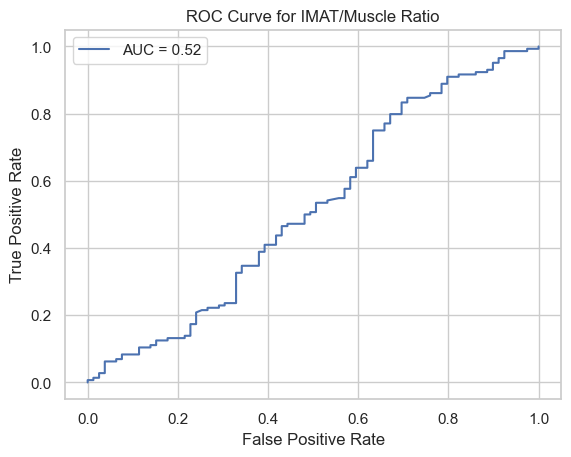

In [138]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert 'complications' to binary values (0 for 'no', 1 for 'yes')
merged_df['complications_binary'] = merged_df['complications'].map({'no': 0, 'yes': 1})

# Compute IMAT to muscle ratio
merged_df['IMAT_to_Muscle_Ratio'] = merged_df['whole_scan_intramusc. adipose tissu (mean)'] / merged_df['abdominal_cavity_muscle volume (mean)']

# ROC curve for the ratio
fpr, tpr, _ = roc_curve(merged_df['complications_binary'], merged_df['IMAT_to_Muscle_Ratio'], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for IMAT/Muscle Ratio")
plt.legend()
plt.savefig(r'C:\Users\anish\Downloads\Technicial_test\ROC_Curve.png')
plt.show()


# Impact of Body Composition on Overall Survival
This section uses Cox regression to explore the relationship between body composition and survival.

In [68]:
print(merged_df['Death during follow-up'].head())


0     no
1    yes
2    yes
3    yes
4    yes
Name: Death during follow-up, dtype: object


In [69]:
# Map 'yes' to 1 and 'no' to 0
merged_df['Death during follow-up'] = merged_df['Death during follow-up'].map({'yes': 1, 'no': 0})

# Check the first few values to confirm the mapping
print(merged_df['Death during follow-up'].head())


0    0
1    1
2    1
3    1
4    1
Name: Death during follow-up, dtype: int64


In [70]:
# After fitting, check for any unexpected changes in the data
print(merged_df[['Death during follow-up', 'Overall survival in months from diagnosis']].head())

   Death during follow-up  Overall survival in months from diagnosis
0                       0                                  65.333333
1                       1                                  42.166667
2                       1                                   2.333333
3                       1                                  56.533333
4                       1                                  17.766667


In [73]:
# Import necessary packages
from lifelines import CoxPHFitter

# Initialize the Cox proportional hazards model
cph = CoxPHFitter()

# Fit the model using relevant body composition variables
cph.fit(merged_df[['Overall survival in months from diagnosis', 
                   'whole_scan_muscle volume (mean)', 
                   'whole_scan_total adipose tissue vol (mean)', 
                   'whole_scan_subcutaneous adip. tissu (mean)', 
                   'whole_scan_visceral adipose tissue  (mean)', 
                   'Death during follow-up']], 
        duration_col='Overall survival in months from diagnosis', 
        event_col='Death during follow-up')

# Print the model summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 223 total observations, 72 right-censored observations>
             duration col = 'Overall survival in months from diagnosis'
                event col = 'Death during follow-up'
      baseline estimation = breslow
   number of observations = 223
number of events observed = 151
   partial log-likelihood = -668.18
         time fit was run = 2025-02-14 00:04:04 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                   
whole_scan_muscle volume (mean)             0.00      1.00      0.00           -0.01            0.01                0.99                1.01
whole_scan_total adipose tissue vol (mean)  0.03      1.03      0.02           -0.02            0.07                0.98                1.07
whole_scan_subcutaneous adip. tissu (mean) -0.03      0.97      0.03           -0.08            0.02                0.92                1.02
whole_scan_visceral adipose tissue  (mean) -0.03      0.97      0.03           -0.08            0.02                0.92                1.02

                                            cmp to     z    p  -log2(p)
covariate                                                              
whole_scan_muscle volume (mean)               0.00  0.14 0.89      0.17
whole_scan_total adipose tissue vol (mean)    0.00  1.12 0.26      1.94
whole_scan_subcutaneous adip. tissu (mean)    0.00 -1.16 0.25      2.01
whole_scan_visceral adipose tissue  (mean)    0.00 -1.15 0.25      2.01
---
Concordance = 0.52
Partial AIC = 1344.35
log-likelihood ratio test = 1.58 on 4 df
-log2(p) of ll-ratio test = 0.30

# Visualization of Gender & Age-Related Differences
Boxplots, violin plots, and scatter plots to explore the gender and age differences in body composition.

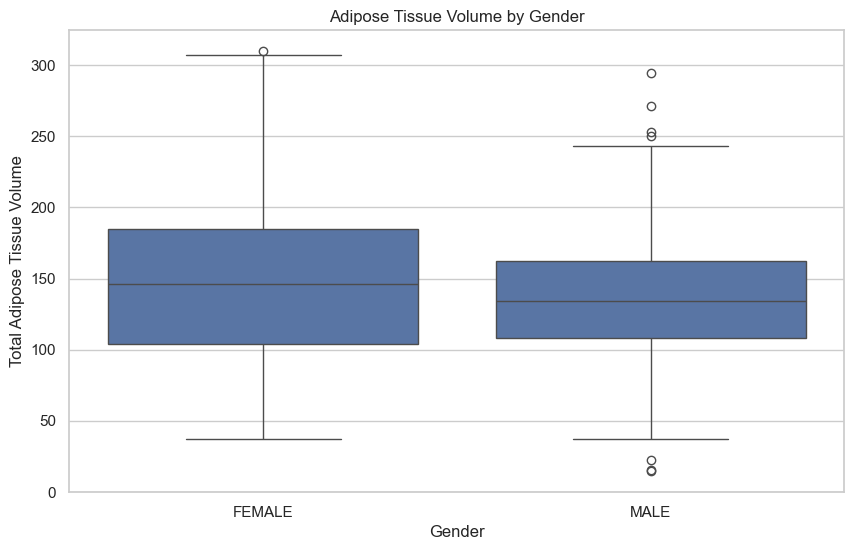

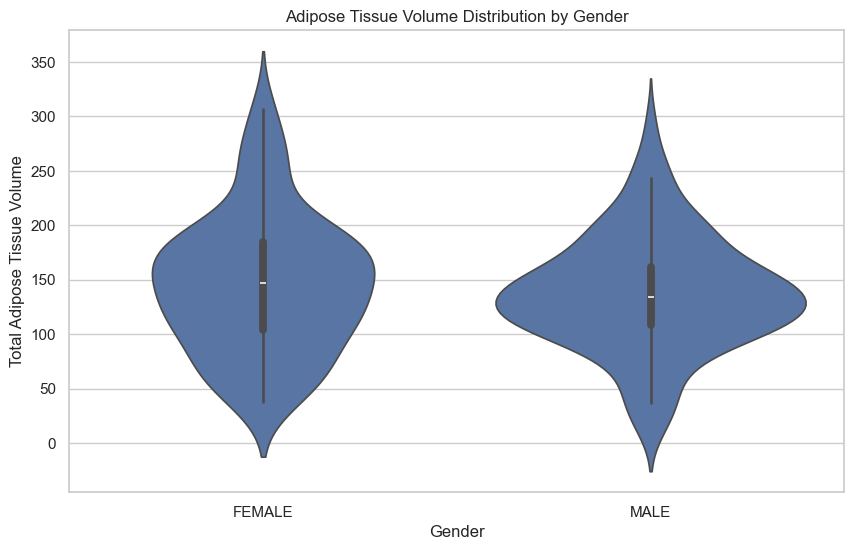

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure 'date_of_birth' is in datetime format and calculate Age
merged_df['date_of_birth'] = pd.to_datetime(merged_df['date_of_birth'])
merged_df['Age'] = (pd.to_datetime('today') - merged_df['date_of_birth']).dt.days // 365

# Set the plotting style
sns.set(style="whitegrid")

# 1. **Boxplot - Gender-based Adipose Tissue Volume**
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex (MALE/FEMALE)', y='whole_scan_total adipose tissue vol (mean)', data=merged_df)
plt.title("Adipose Tissue Volume by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Adipose Tissue Volume")
plt.savefig(r'C:\Users\anish\Downloads\Technicial_test\Adipose_Gender_Boxplot.png')
plt.show()

# 2. **Violin Plot - Gender-based Adipose Tissue Volume**
plt.figure(figsize=(10, 6))
sns.violinplot(x='sex (MALE/FEMALE)', y='whole_scan_total adipose tissue vol (mean)', data=merged_df)
plt.title("Adipose Tissue Volume Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Adipose Tissue Volume")
plt.savefig(r'C:\Users\anish\Downloads\Technicial_test\Adipose_Gender_Violin.png')
plt.show()